U-net
======

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from matplotlib import pyplot as plt

Parameter Settings
-------------------


In [2]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
num_epochs = 50
batch_size = 32
learning_rate = 1e-3
use_gpu = True
image_size = 512


Data Loading
-------------------

We do not center images at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps

#from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

class CustomDataSet(Dataset):
    def __init__(self, input_dir=f'./cropped_input',
                       output_dir=f'./cropped_output', black_and_white=False, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        if black_and_white:
            self.input_dir += '(bw)'
            self.output_dir += '(bw)'
        self.transform = transform
        self.total_imgs = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc_in = os.path.join(self.input_dir, self.total_imgs[idx])
        img_loc_out = os.path.join(self.output_dir, self.total_imgs[idx])
        fig_in = ImageOps.invert(Image.open(img_loc_in))
        fig_out = ImageOps.invert(Image.open(img_loc_out))
        tensor_image_in = self.transform(fig_in)
        tensor_image_out = self.transform(fig_out)

        # внимание: задача инверсной фотолитографии - меняем вход и выход!
        
        #return tensor_image_in, tensor_image_out
        return tensor_image_in, tensor_image_out
        

full_dataset = CustomDataSet(input_dir=f'./cropped_input',
                             output_dir=f'./cropped_output', black_and_white=False, transform=img_transform)

train_size = 3000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(3000, 1406, 94, 44)

In [5]:
train_dataset[0][0].shape

torch.Size([1, 512, 512])

In [6]:
for batch, _ in train_dataloader:
    print(batch.shape)
    break

torch.Size([32, 1, 512, 512])


U-net
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [7]:
import functools

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
    
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

unet = UnetGenerator(input_nc=1, output_nc=1, num_downs=6, ngf=16)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
unet = unet.to(device)

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params, ', device: ', device)

Number of parameters: 1829025 , device:  cuda:0


Train U-net
--------

Training ...
Epoch [1 / 50] time: 68.66 (sec) average reconstruction error: 1661086.044548
Validation error: 715900.738636


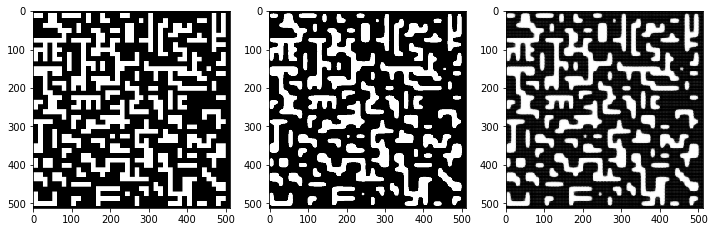

Epoch [2 / 50] time: 68.55 (sec) average reconstruction error: 533307.688497
Epoch [3 / 50] time: 68.69 (sec) average reconstruction error: 399647.081449
Epoch [4 / 50] time: 68.58 (sec) average reconstruction error: 369341.834109
Epoch [5 / 50] time: 70.76 (sec) average reconstruction error: 327565.433843
Epoch [6 / 50] time: 71.87 (sec) average reconstruction error: 306763.508810
Validation error: 300954.044389


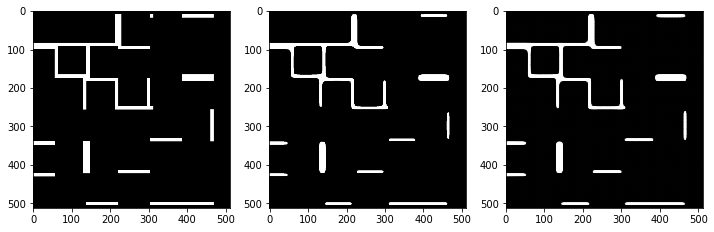

Epoch [7 / 50] time: 70.18 (sec) average reconstruction error: 307878.547540
Epoch [8 / 50] time: 69.78 (sec) average reconstruction error: 306701.362866
Epoch [9 / 50] time: 68.83 (sec) average reconstruction error: 301280.690824
Epoch [10 / 50] time: 68.09 (sec) average reconstruction error: 287552.883311
Epoch [11 / 50] time: 67.96 (sec) average reconstruction error: 280938.425532
Validation error: 278399.555398


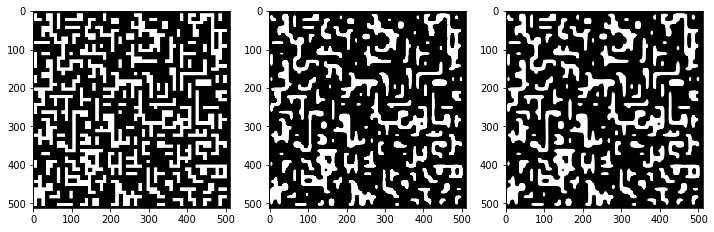

Epoch [12 / 50] time: 69.22 (sec) average reconstruction error: 279867.833112
Epoch [13 / 50] time: 70.94 (sec) average reconstruction error: 274417.268451
Epoch [14 / 50] time: 66.85 (sec) average reconstruction error: 274648.308843
Epoch [15 / 50] time: 67.55 (sec) average reconstruction error: 268715.708112
Epoch [16 / 50] time: 70.35 (sec) average reconstruction error: 267349.077626
Validation error: 285768.166548


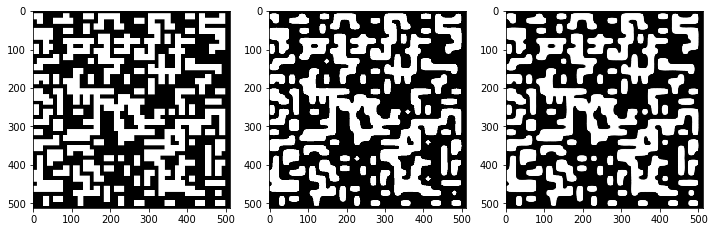

Epoch [17 / 50] time: 70.01 (sec) average reconstruction error: 273531.506815
Epoch [18 / 50] time: 70.24 (sec) average reconstruction error: 269395.365359
Epoch [19 / 50] time: 70.60 (sec) average reconstruction error: 262179.532912
Epoch [20 / 50] time: 70.72 (sec) average reconstruction error: 263865.976230
Epoch [21 / 50] time: 69.49 (sec) average reconstruction error: 258884.119016
Validation error: 265865.713778


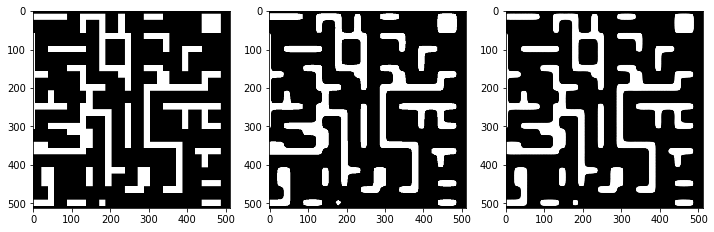

Epoch [22 / 50] time: 72.13 (sec) average reconstruction error: 261799.180352
Epoch [23 / 50] time: 71.53 (sec) average reconstruction error: 262899.820811
Epoch [24 / 50] time: 70.43 (sec) average reconstruction error: 264416.141456
Epoch [25 / 50] time: 70.71 (sec) average reconstruction error: 257631.648271
Epoch [26 / 50] time: 70.52 (sec) average reconstruction error: 258969.882646
Validation error: 266403.107955


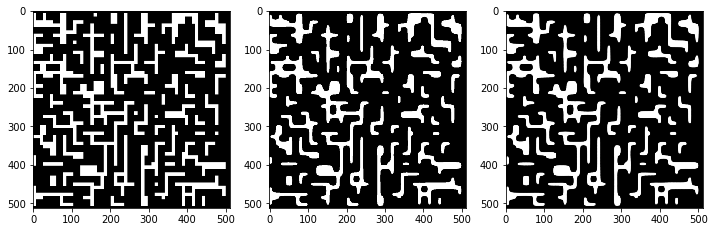

Epoch [27 / 50] time: 71.11 (sec) average reconstruction error: 256812.461769
Epoch [28 / 50] time: 71.15 (sec) average reconstruction error: 259975.854721
Epoch [29 / 50] time: 70.15 (sec) average reconstruction error: 251745.324634
Epoch [30 / 50] time: 73.03 (sec) average reconstruction error: 251984.523271
Epoch [31 / 50] time: 71.27 (sec) average reconstruction error: 253672.577793
Validation error: 261926.618963


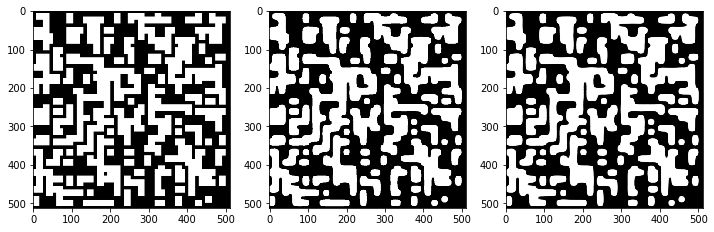

Epoch [32 / 50] time: 69.71 (sec) average reconstruction error: 250095.452959
Epoch [33 / 50] time: 70.89 (sec) average reconstruction error: 247142.487201
Epoch [34 / 50] time: 69.37 (sec) average reconstruction error: 246457.277593
Epoch [35 / 50] time: 69.51 (sec) average reconstruction error: 245502.789229
Epoch [36 / 50] time: 71.63 (sec) average reconstruction error: 244394.746343
Validation error: 267870.719460


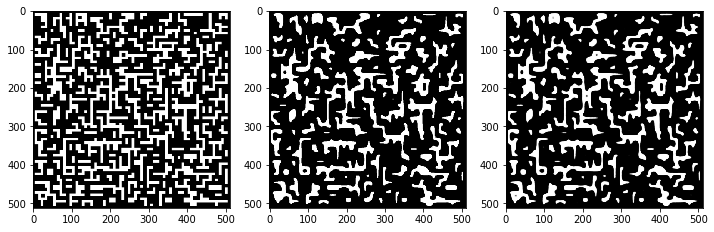

Epoch [37 / 50] time: 71.10 (sec) average reconstruction error: 243435.667719
Epoch [38 / 50] time: 68.39 (sec) average reconstruction error: 241794.260805
Epoch [39 / 50] time: 68.62 (sec) average reconstruction error: 240756.499169
Epoch [40 / 50] time: 67.99 (sec) average reconstruction error: 242260.957447
Epoch [41 / 50] time: 81.11 (sec) average reconstruction error: 239488.105053
Validation error: 264763.735795


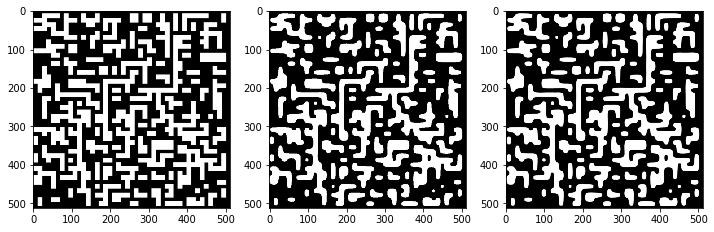

Epoch [42 / 50] time: 76.38 (sec) average reconstruction error: 239253.653424
Epoch [43 / 50] time: 74.67 (sec) average reconstruction error: 238770.843085
Epoch [44 / 50] time: 76.43 (sec) average reconstruction error: 238663.139628
Epoch [45 / 50] time: 75.23 (sec) average reconstruction error: 238081.867188
Epoch [46 / 50] time: 74.92 (sec) average reconstruction error: 236184.018783
Validation error: 267732.061790


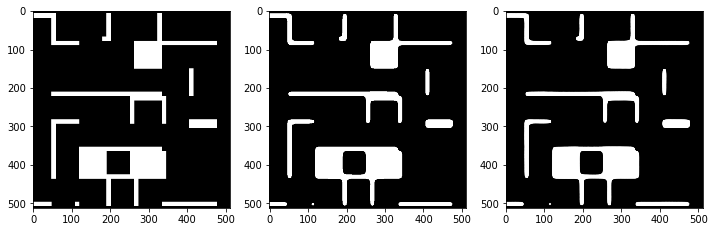

Epoch [47 / 50] time: 74.57 (sec) average reconstruction error: 234273.600731
Epoch [48 / 50] time: 75.66 (sec) average reconstruction error: 234591.149435
Epoch [49 / 50] time: 75.28 (sec) average reconstruction error: 233652.802859
Epoch [50 / 50] time: 75.11 (sec) average reconstruction error: 233272.366356


In [8]:
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
unet.train()

train_loss_avg = []
test_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    start_time = time.time()
    unet.train()
    for image_batch, out_image_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        out_image_batch = out_image_batch.to(device)

        # unet reconstruction
        recon_image_batch = unet(image_batch)
        
        # reconstruction error
        loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                        out_image_batch.view(-1, image_size**2), reduction='sum')

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
          
    train_loss_avg[-1] /= num_batches
    end_time = time.time()
    print('Epoch [%d / %d] time: %.2f (sec) average reconstruction error: %f' % (epoch+1, num_epochs, end_time-start_time, train_loss_avg[-1]))
      
    if epoch % 5 == 0:
        test_loss = []
        unet.eval()
        with torch.no_grad():
            for image_batch, out_image_batch in test_dataloader:
                image_batch = image_batch.to(device)
                out_image_batch = out_image_batch.to(device)
                recon_image_batch = unet(image_batch)
                loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                              out_image_batch.view(-1, image_size**2), reduction='sum')
                test_loss.append(loss.item())

            test_loss_avg.append(np.mean(test_loss))
            print('Validation error: %f' % (test_loss_avg[-1]))

            fig, ax = plt.subplots(1,3, figsize=(12,5))
            ax[0].imshow(image_batch[0].cpu().detach().squeeze(), cmap='gray')
            ax[1].imshow(out_image_batch[0].cpu().detach().squeeze(), cmap='gray')
            ax[2].imshow(recon_image_batch[0].cpu().detach().squeeze(), cmap='gray')
            plt.show()

            if not os.path.isdir('./Unet_checkpoints'):
                os.makedirs('./Unet_checkpoints')
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': unet.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': train_loss_avg,
                        'val_loss': test_loss_avg
                        }, './Unet_checkpoints/Unet_epoch_{}.pth'.format(epoch))

#         model = TheModelClass(*args, **kwargs)
#         optimizer = TheOptimizerClass(*args, **kwargs)

#         checkpoint = torch.load(PATH)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']

#         model.eval()
#         # - or -
#         model.train()

Plot Training Curve
--------------------

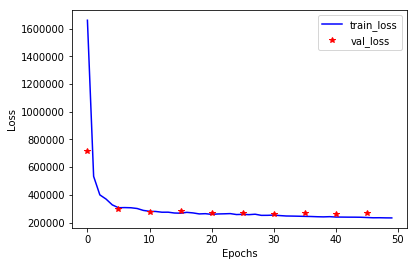

In [10]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'b', label='train_loss')
plt.plot(range(0,50,5), test_loss_avg, 'r*', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained VAE
-----------------------------

In [0]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

Evaluate on the Test Set
-------------------------

In [0]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807126


Visualize Reconstructions
--------------------------

Original images


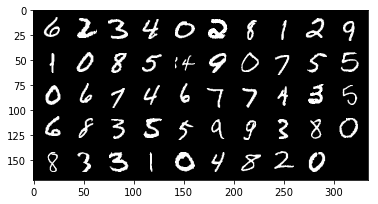

VAE reconstruction:


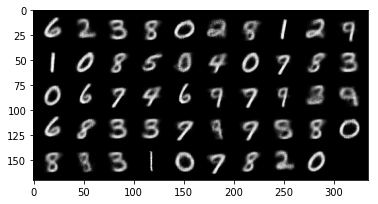

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

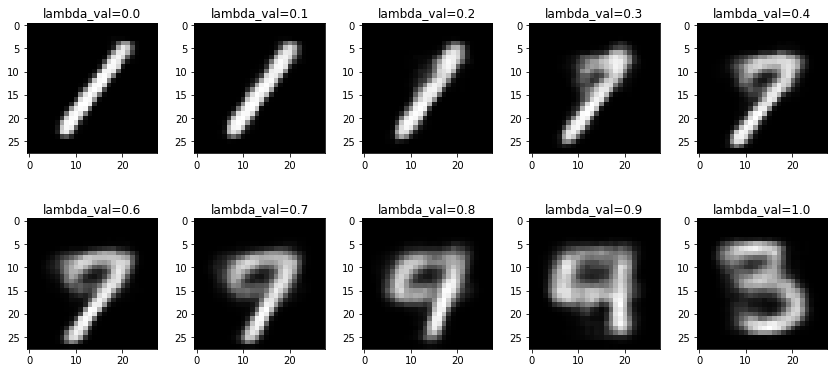

In [0]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

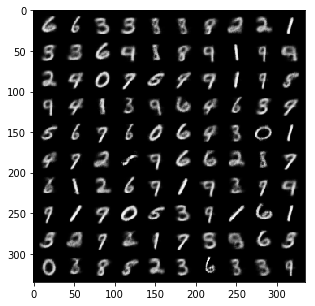

In [0]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

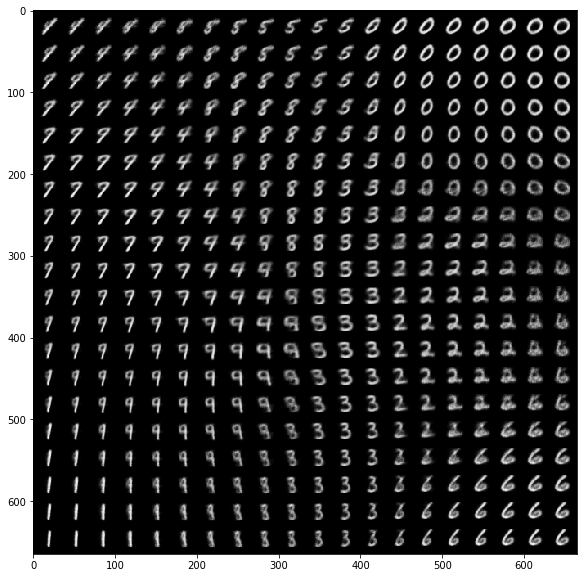

In [0]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()